# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

## Imports

In [43]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from models.bertFull import BertFull


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Thu Feb 22 10:42:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8               3W /  80W |     53MiB /  8188MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "bert-base-uncased"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

### Dataset Loading
 

In [53]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Taking a look to same utterance examples

In [7]:
display_utterance(dataframe=df, utterance_id='utterance_6')
display_utterance(dataframe=df, utterance_id='utterance_456')
display_utterance(dataframe=df, utterance_id='utterance_2005')


Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


[START] frase1_dialogo1 [SEP] frase2_dialogo1 [SEP] ... [END]
[START] frase1_dialogo2 [SEP] ...
...

Frase, speaker, id_dialogo

### Removing NaN Values

In [7]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

#### Utterances Analysis

In [8]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


#### Speaker Emotion distribution  

In [52]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


In [9]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers
index,,,,
utterance_1943,"[Phoebe, Rachel, Phoebe, Rachel, Phoebe]","[surprise, neutral, joy, neutral, neutral]","[Rach?, I'll be out in a second., Oh. It's ju...","[0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_3949,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_767,"[Danny, Joey, Chandler, Joey, Chandler]","[disgust, neutral, surprise, neutral, disgust]",[so we finally get to the top of the mountain ...,"[0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_2319,"[Kim, Nancy, Rachel, Kim, Rachel, Nancy, Kim, ...","[neutral, joy, joy, neutral, neutral, neutral,...","[So, we're decided, no on plaid, yes on pink?,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2563,"[Monica, Chandler, Monica, Chandler, Monica]","[joy, joy, sadness, neutral, joy]","[You're so efficient. I love you!, Let's go!, ...","[0.0, 0.0, 0.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_1618,"[Frank, Phoebe, Phoebe, Phoebe, Phoebe, Phoebe]","[neutral, disgust, neutral, joy, surprise, joy]","[Well, I don't think this, y'know., No, no, no...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
utterance_3787,"[Phoebe, Rachel, Phoebe, Phoebe]","[neutral, surprise, surprise, sadness]","[Y'know, you're friend's getting married, it's...","[0.0, 0.0, 0.0, 1.0]"
utterance_1983,"[Rachel, Rachel, Monica, Rachel, Monica, Rachel]","[surprise, neutral, neutral, surprise, neutral...","[Oh Mon, listen I have to ask!, Okay, Joey Tri...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2117,"[Chandler, All, Chandler, Joey, Chandler]","[neutral, neutral, surprise, surprise, neutral]","[Alright, so I'm back in high school, I'm stan...","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_626,"[Joey, Monica, Rachel, Monica, Rachel, Rachel,...","[neutral, joy, joy, neutral, surprise, anger, ...","[We did?, You owe me 20 bucks., Thank you. Tha...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,speakers,emotions,utterances,triggers
index,,,,
utterance_109,"[Monica, Chandler, Monica, Chandler, Monica, M...","[surprise, joy, neutral, joy, surprise, anger]",[Wow! That Mike thing was interesting! I don't...,"[0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
utterance_2491,"[Chandler, Monica, Chandler, Monica, Chandler,...","[sadness, disgust, fear, anger, sadness, neutr...","[I am so, so, so, so sorry!, Uh-huh., And I wi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1914,"[Rachel, Phoebe, Rachel, Phoebe, Rachel, Phoeb...","[joy, joy, neutral, neutral, neutral, neutral,...","[Hi Pheebs!, Hi!, How are ya?, Good., Umm Phee...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_1376,"[Ross, Rachel, Ross, Rachel, Ross, Chandler, R...","[neutral, neutral, neutral, surprise, neutral,...","[Okay, I've got three of my five., Three of yo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
utterance_1667,"[Joey, Rachel, Joey, Rachel]","[neutral, neutral, neutral, surprise]","[Oh yeah-yeah, the lobster., Yeah, I mean I wa...","[0.0, 0.0, 1.0, 0.0]"


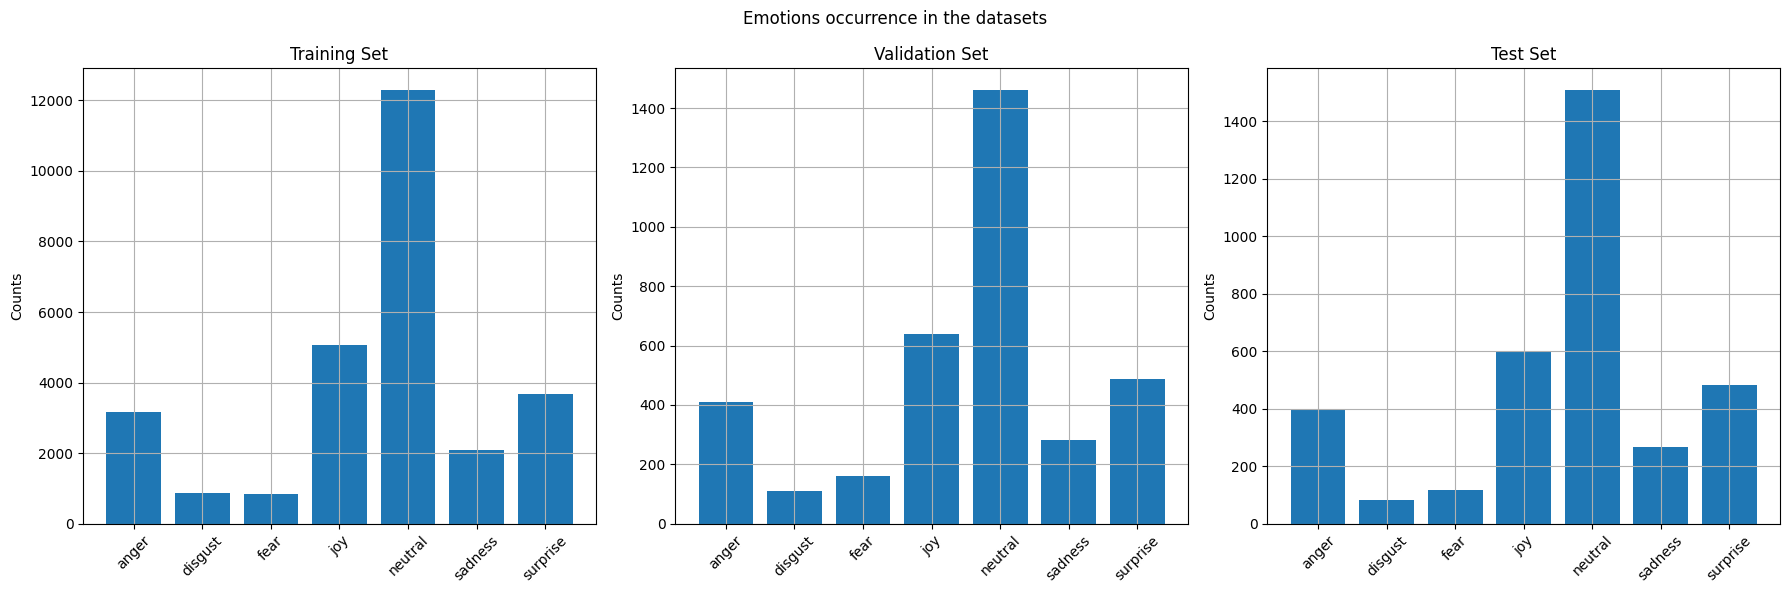

In [10]:
plot_emotion_distribution(train_df, val_df, test_df)


## Models


### Random Classifier

In [12]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_utterance(dataframe=new_test_df, utterance_id=0)    

,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,surprise,Wow! That Mike thing was interesting! I don't ...,0.0,surprise,0
1,Chandler,joy,"I do! Want a hint? huh? ""I do"" ""I do"".",0.0,fear,1
2,Monica,neutral,"Ok, I'm sensing that this is some kind of word...",0.0,neutral,0
3,Chandler,joy,David is going to propose to Phoebe.,1.0,neutral,0
4,Monica,surprise,What? Why?,1.0,disgust,0
5,Monica,anger,"Chandler, we have talked about this.",1.0,joy,1


### Majority Classifier

In [21]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_utterance(dataframe=new_test_df, utterance_id=0)



,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,Hi! I'm Dr. Drake Remoray and I have a few rou...,0.0,neutral,0.0
1,Man,surprise,Really? I've been dealing with Dr. Wells.,0.0,neutral,0.0
2,Joey,neutral,"I know, but I'm a neurologist.",0.0,neutral,0.0
3,Joey,neutral,"And just to be on the safe side, Dr. Wells wan...",0.0,neutral,0.0
4,Man,surprise,Dr. Wells is a woman.,0.0,neutral,0.0
5,Joey,neutral,"That was a test. Good response. All right, ful...",0.0,neutral,0.0
6,Man,neutral,Clifford Burnett.,0.0,neutral,0.0
7,Joey,neutral,Date of birth?,0.0,neutral,0.0
8,Cliff,neutral,November 16,0.0,neutral,0.0
9,Joey,neutral,Age?,1.0,neutral,0.0


### Bert Models

In [54]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_INT = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
INT_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

print("Aaahhh le emozioni: ", EMOTIONS)

Aaahhh le emozioni:  ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


In [ ]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY) 

In [ ]:
dialogo = [
    "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
    "You must've had your hands full.",
    "That I did. That I did.",
    "So let's talk a little bit about your duties.",
    "My duties? All right."
]

# Preparazione dell'input
tokens = [bert_tokenizer.cls_token]  # Inizia con [CLS]
for frase in dialogo:
    tokens += bert_tokenizer.tokenize(frase) + [bert_tokenizer.sep_token]  # Aggiungi frase e [SEP]

# Converti in ID e tronca se necessario
input_ids = bert_tokenizer.convert_tokens_to_ids(tokens)[:512]  # Assicurati di non superare il limite di 512 token

input_ids_tensor = torch.tensor([input_ids])
print(np.shape(input_ids_tensor))
print(bert_tokenizer.sep_token)


In [ ]:
from models.bertFreezed import BertFreezed

pos = [idx for idx in range(len(input_ids_tensor[0])) if input_ids_tensor[0, idx] == 102]
print(pos)
bertino = BertFreezed(bert_model)
bertino(input_ids_tensor, pos)
